## Load necessary libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import time, copy

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, f1_score


# setting random seeds for reproducibility of results
torch.manual_seed(0)
np.random.seed(0)


## Load and transform a dataset

__MNIST__ dataset contains images of 0 to 9 handwritten digits.
__FashionMNIST__ dataset contains images of ten (labeled 0 to 9) different clothing categories: T-shirts/tops, trousers, pullovers, dresses, coats, sandals, shirts, sneakers, bags, and ankle boots.

In [2]:

img_HW = 16            
d = img_HW**2   

print(f'image Hight = image Width = {img_HW}')
print(f'img_HW**2 = dimension of the Hilbert space = d = {d} \n')


#================================================================================================


transform = transforms.Compose([ 
    transforms.Resize((img_HW, img_HW)),                          # resize image 
    transforms.ToTensor(),                                        # to transform an image into a tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,))                 # to put all the values between -1 and 1
])



def load_dataset(name):
    print(name,'\n')
    if name == "FashionMNIST":
        train_dataset = datasets.FashionMNIST(root="/home/qpi/Documents/QML/image_datasets/FashionMNIST", 
                                              train=True, download=True, transform=transform)
        test_dataset = datasets.FashionMNIST(root="/home/qpi/Documents/QML/image_datasets/FashionMNIST", 
                                             train=False, download=True, transform=transform)
    elif name == "MNIST":
        train_dataset = datasets.MNIST(root="/home/qpi/Documents/QML/image_datasets/MNIST", 
                                       train=True, download=True, transform=transform)
        test_dataset = datasets.MNIST(root="/home/qpi/Documents/QML/image_datasets/MNIST", 
                                      train=False, download=True, transform=transform)
    return train_dataset, test_dataset 


#================================================================================================


train_dataset, test_dataset = load_dataset("MNIST")        # Choose either "MNIST" or "FashionMNIST"
print(f'number of (train, test) examples = {len(train_dataset), len(test_dataset)}')


num_classes = 10
print(f'number of classes = {num_classes}')
classes = list(range(num_classes))


image Hight = image Width = 16
img_HW**2 = dimension of the Hilbert space = d = 256 

MNIST 

number of (train, test) examples = (60000, 10000)
number of classes = 10


### View a training example:

x of torch.Size([1, 16, 16]) :


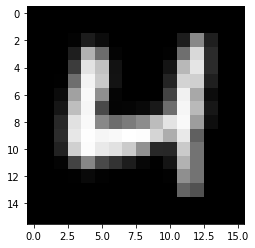

true label = y = 4

(x_min, x_max) = (-1.0, 0.984)


In [3]:
idx = np.random.choice(len(train_dataset))

x = train_dataset[idx][0]
print(f'x of {x.shape} :')

plt.imshow(x[0], cmap='gray')
plt.show()

print(f'true label = y = {train_dataset[idx][1]}\n')

print(f'(x_min, x_max) = {x.min().item(), round(x.max().item(),3)}')

## Define Quantum Machine Learning (QML) model : Interferometric Neural Network (INN)

In [4]:

class parallel_interferometers(nn.Module):
    def __init__(self, dim_out, dim_in):
        super(parallel_interferometers, self).__init__()
        
        self.dim_out = dim_out                                            # output dimention 
        self.dim_in = dim_in                                              # input dimention 
                                          
        torch.manual_seed(1)                         # setting a specific seed for reproducibility of results
        phases = torch.randn((1, dim_out, dim_in), dtype=torch.float)     # Initialize learnable phases 
        nn.init.xavier_uniform_(phases)     
        self.phases = nn.Parameter(phases) 
        
        
    def forward(self, x):                          # x.shape = (batch_size, 1 or dim_out, dim_in) 
        x = x * torch.exp(1j * self.phases)        # Perform dim_out parallel phase shifters
        x = torch.fft.fft(x, norm='ortho')         # Perform parallel 1D Fast Fourier Transforms (beamsplitters)
        return x                                   # x.shape = (batch_size, dim_out, dim_in)
    

__An interferometric block :__ $d_\text{out}$ parallel sequences of interferometers. Each sequence (represented by, $U(\Phi)$, square) has $L$ interferometers.

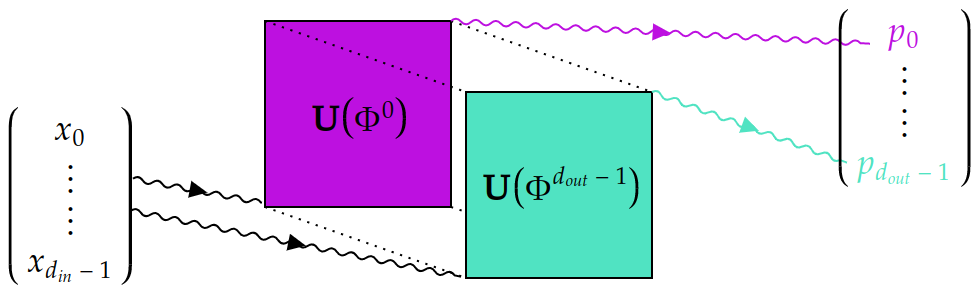


In [5]:

class interferometric_block(nn.Module):                                      
    def __init__(self, dim_out, dim_in, L, channels=1):                 
        super(interferometric_block, self).__init__()
        
        self.dim_out = dim_out                                            # output dimention 
        self.dim_in = dim_in                                              # input dimention 
        self.L = L                                                        # number of quantum layers
        self.channels = channels
        
        self.phase_filters_layers = nn.ModuleList([parallel_interferometers(dim_out, dim_in) for _ in range(L)])
        
        
    def forward(self, x):
        x = x.view(-1, self.channels, self.dim_in)
        
        x = F.normalize(x, dim=-1)           # amplitude encodings  x -->  |x>
        
        #------------------------------------------------------------------------------------ 
        
        x = torch.fft.fft(x, norm='ortho')   # First ID Fast Fourier Transforms (beamsplitters)
        
        for phase_filters in self.phase_filters_layers:
            x = phase_filters(x)
            
         #------------------------------------------------------------------------------------
            
        x = x*(x.conj())                     # measurement in the computational basis and getting probabilities 
        x = torch.real(x)                    # dropping the imaginary components 0j

        x = x[:,:,0]                         # probability of getting 0 outcome from each sequence
    
        return x 
    
    

Here, __an Interferometric Neural Networks (INN)__ is made of $M=2$ blocks, where the dimensions $\textbf{d}ims=(d_0,d_1,d_2)=(2^8, 2^6, 10)$ and
the quantum layers $\textbf{L}s = (L_0,L_1)=(1,1)$ or $\textbf{L}s=(2,2)$.

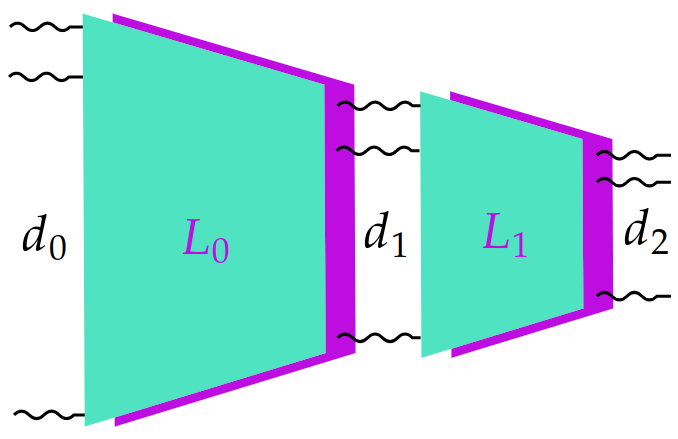


In [6]:
   
class INN(nn.Module):                               # Define QML model = Interferometric Neural Network (INN)
    def __init__(self, dims, Ls):                                
        super(INN, self).__init__()
        
        self.dims = dims                            # dimension of a feature vector before or after a block
        self.Ls = Ls                                # number of quantum layers in a block
        self.M = len(dims) - 1                      # number of blocks = M
        
        
        self.blocks = nn.ModuleList()               # Initialize an empty ModuleList
        
        for i in range(self.M-1):
            self.blocks.append(interferometric_block(dim_out=dims[i+1], dim_in=dims[i], L=Ls[i]))
        
        self.last_block = interferometric_block(dim_out=dims[-1], dim_in=dims[-2], L=Ls[-1])
        
        
    def forward(self, x):  
        
        for block in self.blocks:
            x = block(x)
            
        x = self.last_block(x)
        
        return x 

## Define device, hyperparameters, dataloader

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'device = {device}')
torch.set_num_threads(1)                                             # it is for reproducibility of results

#==================================================================

print(f'image Hight = image Width = {img_HW}')
print(f'dimension of the Hilbert space = d = {d}\n')



dims = [d, 2**6, num_classes]
Ls = [2,2]                                           # set Ls = [2,2] or Ls = [1, 1] to get our reported Results
print(f'dimension of a feature vector after a block = {dims}')
print(f'number of quantum layers in a block = {Ls}')

num_phases = int(np.sum(np.array(dims[:-1]) * Ls * dims[1:]))
print(f'number of learnable (parameters) phases in the model = {num_phases}\n')

#---------------------------------------------------------------
# optimizer Adam's hyperparameters

lr = 1e-2

b1 = 0.5
b2 = 0.9

#==================================================================

batch_size = 2**5
epochs = 3

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
num_batches = len(train_dataloader)
print(f'number of batches = {num_batches}, batch_size = {batch_size}\n')

test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

device = cpu
image Hight = image Width = 16
dimension of the Hilbert space = d = 256

dimension of a feature vector after a block = [256, 64, 10]
number of quantum layers in a block = [2, 2]
number of learnable (parameters) phases in the model = 34048

number of batches = 1875, batch_size = 32



## Training...

In [8]:
%%time

                        
model = INN(dims=dims, Ls=Ls).to(device)                                   # start the QML model instance
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(b1, b2))    # define optimizer for the model
loss_fn = nn.CrossEntropyLoss()                                            # define loss functions for the model



#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Train_Loss = []
for t in range(epochs):
    print()
    print(f"Epoch {t:2d} ---------------------------------- \n")
    for batch_idx, (X, y) in enumerate(train_dataloader):

        X, y = X.to(device), y.to(device) 
        
        out = model(X)                            # Perform a single forward pass through the model
        loss = loss_fn(out, y)
   
        model.zero_grad()                         # Clear gradients 
        loss.backward(retain_graph=True)          # Derive gradients, backpropagation 
        optimizer.step()                          # Update parameters of the model based on gradients

        #-------------------------------------------------------------------------------
        
        if batch_idx % 200 == 0: 
            print(f'after {batch_idx:4d} batch      train loss: {loss:.4f}') 
            Train_Loss.append(loss.detach().item())
            
                                      
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        
print(f'\n ~~~~~ training is done ~~~~~\n ')
                


Epoch  0 ---------------------------------- 

after    0 batch      train loss: 2.3026
after  200 batch      train loss: 1.8947
after  400 batch      train loss: 1.8236
after  600 batch      train loss: 1.6926
after  800 batch      train loss: 1.6886
after 1000 batch      train loss: 1.5805
after 1200 batch      train loss: 1.5900
after 1400 batch      train loss: 1.6069
after 1600 batch      train loss: 1.6313
after 1800 batch      train loss: 1.5817

Epoch  1 ---------------------------------- 

after    0 batch      train loss: 1.5501
after  200 batch      train loss: 1.5541
after  400 batch      train loss: 1.5664
after  600 batch      train loss: 1.6554
after  800 batch      train loss: 1.6449
after 1000 batch      train loss: 1.6025
after 1200 batch      train loss: 1.5900
after 1400 batch      train loss: 1.5905
after 1600 batch      train loss: 1.6410
after 1800 batch      train loss: 1.6129

Epoch  2 ---------------------------------- 

after    0 batch      train loss: 1.583

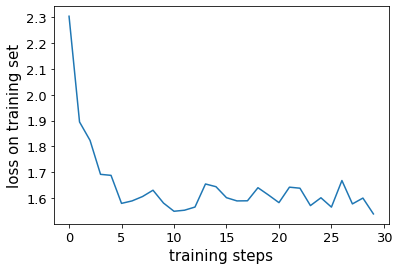

In [9]:
plt.plot(Train_Loss, label='train set')
plt.ylabel('loss on training set',fontsize=15)
plt.xlabel('training steps',fontsize=15)
plt.yticks(fontsize=13)
plt.xticks(fontsize=13)
plt.show()

## Performance estimation

In [10]:
def probabilities(dataloader, model):
    model.eval()
    with torch.no_grad():
        ys, probs = torch.tensor([]), torch.tensor([]) 
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            ys = torch.cat((ys, y), 0)
            
            prob = model(X)
            probs = torch.cat((probs, prob), 0)
    return ys, probs



def performance_estimate(y, prob, dataset_name):
    '''With a model, this function computes loss and other metrics on the training or test set'''
    y = y.to(torch.int64)
    loss = loss_fn(prob, y).item()
    
    prob = F.softmax(prob, dim=-1)                              # to make individual probabilities add to one
    au_roc = roc_auc_score(y, prob, multi_class='ovr')
    
            
    y_pred = prob.argmax(1)
    f1 = f1_score(y, y_pred, average='macro')
            
    print(classification_report(y, y_pred))
    print(confusion_matrix(y, y_pred), f"= confusion matrix on {dataset_name} set")
    
    print(f"average f1_score on {dataset_name} set = {f1:.2f}")
    print(f"loss on {dataset_name} set = {loss:.3f}")
    print(f"roc_auc_score on {dataset_name} set = {au_roc:.2f} \n")
    
    return

#==================================================================================================


y_train, prob_train = probabilities(train_dataloader, model)
performance_estimate(y_train, prob_train, 'train')

y_test, prob_test = probabilities(test_dataloader, model)
performance_estimate(y_test, prob_test, 'test')


              precision    recall  f1-score   support

           0       0.95      0.97      0.96      5923
           1       0.96      0.97      0.97      6742
           2       0.92      0.91      0.91      5958
           3       0.88      0.92      0.90      6131
           4       0.94      0.91      0.93      5842
           5       0.90      0.91      0.90      5421
           6       0.94      0.96      0.95      5918
           7       0.94      0.93      0.94      6265
           8       0.94      0.85      0.89      5851
           9       0.89      0.92      0.90      5949

    accuracy                           0.93     60000
   macro avg       0.93      0.93      0.93     60000
weighted avg       0.93      0.93      0.93     60000

[[5757    4   19   18    9   25   47    7   33    4]
 [   4 6571   57   18   10   16   12   12   30   12]
 [  62   20 5430  107   66   17   61   82   99   14]
 [  16    6  161 5628   11   84   24   83   67   51]
 [   7   23   63    6 5341   

## Results:

With Ls = [2, 2] we get

accuracy on MNIST test set = 0.93 <br>
average f1_score on MNIST test set = 0.93

accuracy on FashionMNIST test set = 0.83 <br>
average f1_score on FashionMNIST test set = 0.83


$----------------------------------------$


With Ls = [1, 1] we get

accuracy on MNIST text set = 0.89 <br>
average f1_score on MNIST test set = 0.89

accuracy on FashionMNIST test set = 0.78 <br>
average f1_score on FashionMNIST test set = 0.77


## Predict a test example's class

x of torch.Size([1, 16, 16]) :


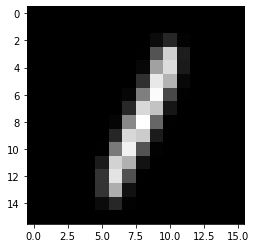

true label = y = 1

predicted label = 1



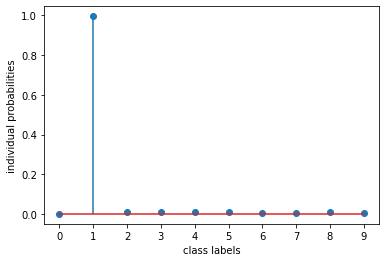

The individual probabilities do not necessarily add to one: their sum = 1.051
loss = 1.4691


True

In [11]:
idx = np.random.choice(len(test_dataset))

x = test_dataset[idx][0]
print(f'x of {x.shape} :')
plt.imshow(x[0], cmap='gray')
plt.show()

y_ = test_dataset[idx][1]
print(f'true label = y = {y_}\n')


prob = model(x[0]).detach().flatten()
#prob = F.softmax(prob, dim=-1)                      # to make individual probabilities add to one
pred = prob.argmax().item()
print(f'predicted label = {pred}\n')

plt.stem(classes, prob)
plt.ylabel('individual probabilities')
plt.xlabel('class labels')
plt.xticks(classes)
plt.show()


print(f'The individual probabilities do not necessarily add to one: their sum = {round(torch.sum(prob).item(),3)}')
print(f'loss = {round(-torch.log(F.softmax(prob, dim=-1)[y_]).item(), 4)}')

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params == num_phases

# 

$ $